In [1]:
import numpy as np
import os as os
from matplotlib import pyplot
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.layers import  Convolution2D, MaxPooling2D
from tensorflow.python.keras import applications
from tensorflow.python.keras.layers import Dropout, Flatten, Dense, Activation
from tensorflow.keras import optimizers

In [2]:
longitud, altura = 224, 224
batch_size = 100

data_entrenamiento="./DermMel/train_sep"
data_validacion="./DermMel/valid"

#Usamos la tecnica de "data augmentation" para agrandar el conjunto de datos y realizar un entrenamiento más robusto
# en cuanto a variabilidad fotográfica
entrenamiento_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,#intensidad
    zoom_range=0.2,#zoom
    horizontal_flip=True)#giro horizontal

test_datagen = ImageDataGenerator(rescale=1. / 255)

entrenamiento_generador = entrenamiento_datagen.flow_from_directory(data_entrenamiento,
    target_size=(altura, longitud),batch_size=batch_size,class_mode='categorical')


validacion_generador = test_datagen.flow_from_directory(
    data_validacion,
    target_size=(altura, longitud),
    batch_size=batch_size,
    class_mode='categorical')

Found 10682 images belonging to 2 classes.
Found 3562 images belonging to 2 classes.


In [83]:
#Experimento 2 de Inception V3: 
#Aparte del cambio en las imágenes de entrenamiento, añadimos capas del modelo preentrenado como entrenables a la nueva red 
#y añadimos más capas que en la anterior aproximación.

base_model = tf.keras.applications.InceptionV3(include_top=False,input_shape=(224,224,3),classes=2,weights='imagenet')
base_model.layers.pop()
tam=len(base_model.layers)
print(tam)
#dejamos las 10 últimas capas como entrenables:
for i in range(0,tam-11):
    base_model.layers[i].trainable=False #para ello fijamos el parámetro trainable como false de las capas que no se van a entrenar
    
#obtenemos un resumen del modelo    
base_model.summary()
model = tf.keras.models.Sequential(base_model)

311
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_41 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_2820 (Conv2D)            (None, 111, 111, 32) 864         input_41[0][0]                   
__________________________________________________________________________________________________
batch_normalization_2822 (Batch (None, 111, 111, 32) 96          conv2d_2820[0][0]                
__________________________________________________________________________________________________
activation_2820 (Activation)    (None, 111, 111, 32) 0           batch_normalization_2822[0][0]   
___________________________________________________________________________________

In [84]:
#Capas a añadir:
model.add(keras.layers.GlobalAveragePooling2D())#resumimos los valores de la anterior red neuronal
model.add(keras.layers.Dropout(0.5))#introducimos dropout para disminuir el numero de neuronas para que aprendan sin sobreajuste
model.add(keras.layers.BatchNormalization())#normalizamos las entradas a la siguiente capa
model.add(keras.layers.Flatten())#convertimos los datos en forma de matriz a una columna
model.add(Dense(256, activation='relu'))#Conectamos los datos a de salida de una neurona a la entrada de otra
#realizamos la conexión para clasificar las imágenes como dos clases mediante la función sigmoide
model.add(keras.layers.Dense(2,activation='sigmoid'))

In [85]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_23  (None, 2048)              0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 2048)              0         
_________________________________________________________________
batch_normalization_2916 (Ba (None, 2048)              8192      
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 256)               524544    
_________________________________________________________________
dense_23 (Dense)             (None, 2)               

Epoch 1/5
107/107 [==============================] - 424s 4s/step - loss: 0.4255 - accuracy: 0.8042 - val_loss: 0.2942 - val_accuracy: 0.8630
Epoch 2/5
107/107 [==============================] - 445s 4s/step - loss: 0.3253 - accuracy: 0.8596 - val_loss: 0.2222 - val_accuracy: 0.9186
Epoch 3/5
107/107 [==============================] - 434s 4s/step - loss: 0.3133 - accuracy: 0.8677 - val_loss: 0.2017 - val_accuracy: 0.9234
Epoch 4/5
107/107 [==============================] - 434s 4s/step - loss: 0.3058 - accuracy: 0.8671 - val_loss: 0.1988 - val_accuracy: 0.9206
Epoch 5/5
107/107 [==============================] - 419s 4s/step - loss: 0.2925 - accuracy: 0.8759 - val_loss: 0.1935 - val_accuracy: 0.9236
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


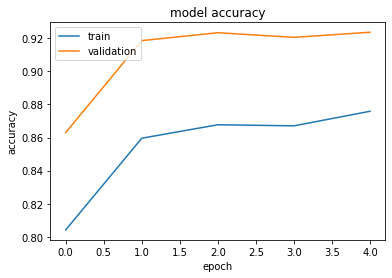

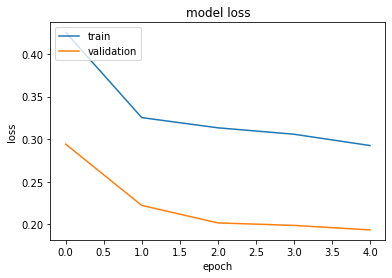

In [86]:
#Volvemos a entrenar el modelo tan solo 5 épocas para ver como va evolucionando:
lr = 0.0004

model.compile(optimizer=optimizers.Adam(lr=lr),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

import numpy
epocas=5#despues de los experimentos

steps_per_epoch = numpy.ceil(entrenamiento_generador.n / batch_size)
validation_steps = numpy.ceil(validacion_generador.n / batch_size)

history2=model.fit_generator(
    entrenamiento_generador,
    steps_per_epoch=steps_per_epoch,
    epochs=epocas,
    validation_data=validacion_generador,
    validation_steps=validation_steps)

model.save('./Experimentos/Nueva configuracion Inception/modelo_tf_inception3-exp2.h5')
model.save_weights('./Experimentos/Nueva configuracion Inception/pesos_tf_inception3-exp2.h5')

import matplotlib.pyplot as plt
print(history2.history.keys())
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [3]:
#Viendo que el modelo resultante puede ser bueno repetimos el proceso para 15 épocas:
base_model = tf.keras.applications.InceptionV3(include_top=False,input_shape=(224,224,3),classes=2,weights='imagenet')
base_model.layers.pop()
tam=len(base_model.layers)
print(tam)
for i in range(0,tam-11):
    base_model.layers[i].trainable=False
    
base_model.summary()
model = tf.keras.models.Sequential(base_model)

311
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
___________________________________________________________________________________

In [4]:
model.add(keras.layers.GlobalAveragePooling2D())
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Flatten())
model.add(Dense(256, activation='relu'))
model.add(keras.layers.Dense(2,activation='sigmoid'))

Epoch 1/15
107/107 [==============================] - 430s 4s/step - loss: 0.4163 - accuracy: 0.8068 - val_loss: 0.3221 - val_accuracy: 0.8549
Epoch 2/15
107/107 [==============================] - 370s 3s/step - loss: 0.3221 - accuracy: 0.8577 - val_loss: 0.2411 - val_accuracy: 0.9082
Epoch 3/15
107/107 [==============================] - 370s 3s/step - loss: 0.3177 - accuracy: 0.8627 - val_loss: 0.2117 - val_accuracy: 0.9239
Epoch 4/15
107/107 [==============================] - 370s 3s/step - loss: 0.3091 - accuracy: 0.8671 - val_loss: 0.2097 - val_accuracy: 0.9228
Epoch 5/15
107/107 [==============================] - 371s 3s/step - loss: 0.3056 - accuracy: 0.8660 - val_loss: 0.2105 - val_accuracy: 0.9250
Epoch 6/15
107/107 [==============================] - 370s 3s/step - loss: 0.2949 - accuracy: 0.8755 - val_loss: 0.1979 - val_accuracy: 0.9253
Epoch 7/15
107/107 [==============================] - 375s 4s/step - loss: 0.2947 - accuracy: 0.8732 - val_loss: 0.1899 - val_accuracy: 0.9250

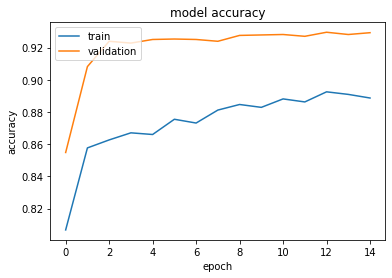

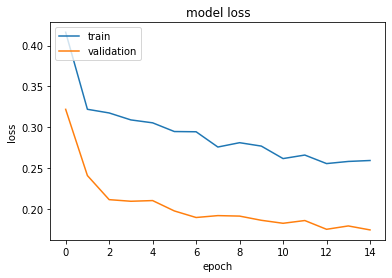

In [6]:
lr = 0.0004

model.compile(optimizer=optimizers.Adam(lr=lr),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

import numpy
epocas=15

steps_per_epoch = numpy.ceil(entrenamiento_generador.n / batch_size)
validation_steps = numpy.ceil(validacion_generador.n / batch_size)

history2=model.fit_generator(
    entrenamiento_generador,
    steps_per_epoch=steps_per_epoch,
    epochs=epocas,
    validation_data=validacion_generador,
    validation_steps=validation_steps)

model.save('./Experimentos/Nueva configuracion Inception/modelo_tf_inception3-exp3.h5')
model.save_weights('./Experimentos/Nueva configuracion Inception/pesos_tf_inception3-exp3.h5')

import matplotlib.pyplot as plt
print(history2.history.keys())
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [19]:
#Experimento 2 de VGG16:
#Repetimos el anterior experimento para vgg16, pero sin añadirle capas del modelo debido al incremento que produce en
#el número de parámetros entrenables (se alcanzan millones de parámetros), que ralentiza la experimentación demasiado.

base_model = tf.keras.applications.vgg16.VGG16(include_top=False,input_shape=(224,224,3),classes=2,weights='imagenet')
base_model.layers.pop()
base_model.trainable=False
tam=len(base_model.layers)
print(tam)
'''
for i in range(0,tam-1):
    base_model.layers[i].trainable=False
'''
base_model.summary()
model = tf.keras.models.Sequential(base_model)

19
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0  

In [20]:
model.add(keras.layers.GlobalAveragePooling2D())
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Flatten())
model.add(Dense(256, activation='relu'))
model.add(keras.layers.Dense(2,activation='sigmoid'))
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 512)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_97 (Batc (None, 512)               2048      
_________________________________________________________________
flatten_3 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_7 (Dense)              (None, 2)               

Epoch 1/15
107/107 [==============================] - 1560s 15s/step - loss: 0.5001 - accuracy: 0.7590 - val_loss: 0.5780 - val_accuracy: 0.7942
Epoch 2/15
107/107 [==============================] - 1552s 15s/step - loss: 0.4411 - accuracy: 0.7927 - val_loss: 0.5118 - val_accuracy: 0.8209
Epoch 3/15
107/107 [==============================] - 1553s 15s/step - loss: 0.4342 - accuracy: 0.7994 - val_loss: 0.4524 - val_accuracy: 0.8316
Epoch 4/15
107/107 [==============================] - 1552s 15s/step - loss: 0.4257 - accuracy: 0.7988 - val_loss: 0.4041 - val_accuracy: 0.8321
Epoch 5/15
107/107 [==============================] - 1552s 15s/step - loss: 0.4228 - accuracy: 0.8020 - val_loss: 0.3798 - val_accuracy: 0.8358
Epoch 6/15
107/107 [==============================] - 1551s 14s/step - loss: 0.4205 - accuracy: 0.8021 - val_loss: 0.3691 - val_accuracy: 0.8408
Epoch 7/15
107/107 [==============================] - 1553s 15s/step - loss: 0.4228 - accuracy: 0.7984 - val_loss: 0.3677 - val_ac

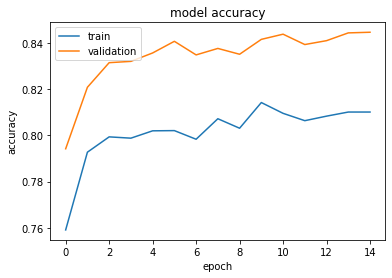

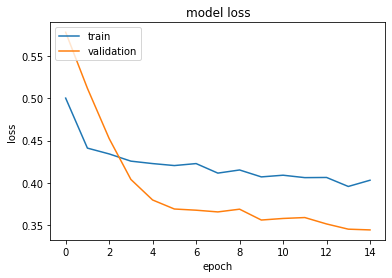

In [21]:
lr = 0.0004

model.compile(optimizer=optimizers.Adam(lr=lr),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

import numpy
epocas=15#se escogen 15 épocas en concreto por limitaciones técnicas dado que las redes resultantes por transfarencia de VGG16, 
#tardan mucho tiempo en entrenar(4 o 5 h) y la temperatura que alcanza la CPU en ese proceso es alta (82 grados)

steps_per_epoch = numpy.ceil(entrenamiento_generador.n / batch_size)
validation_steps = numpy.ceil(validacion_generador.n / batch_size)

history2=model.fit_generator(
    entrenamiento_generador,
    steps_per_epoch=steps_per_epoch,
    epochs=epocas,
    validation_data=validacion_generador,
    validation_steps=validation_steps)

model.save('./Experimentos/Nueva configuracion VGG/modelo_tf_inception3-exp2.h5')
model.save_weights('./Experimentos/Nueva configuracion VGG/pesos_tf_inception2-exp3.h5')

import matplotlib.pyplot as plt
# list all data in history
print(history2.history.keys())
# summarize history for accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()